In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist
from scipy import stats

from src.downsample import downsamp_audio
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.plotting as plotting
import src.emb_manipulator as em


from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models. in any "all models" script we evaluate which one(s) might be best

#the directory has other csvs and i only want today's
#file = [file for file in os.listdir(embedding_dir) if file.startswith("020422") if 'emb' in file] 
#file = '022822_postpartum_moms_20part_emb_ami.csv'

#create a dictionary where each item is the pd df of the embeddings extracted from that model
#all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
#emb = ee.load_embs(os.path.join(embedding_dir,file))

file = '03016_diarized_pyv2.csv'

#create a dictionary where each item is the pd df of the embeddings extracted from that model
#all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb = pd.read_csv(os.path.join(embedding_dir,file), index_col=0)

#choose 'emb_ami' as the embedding model to use because it seemed to result in best preserved high-dimension structure when dimension reduced
#emb = all_embs[emb_models[0]]
emb_down = em.resample_data(emb,1)


#choose 'emb_ami' as the embedding model to use because it seemed to result in best preserved high-dimension structure when dimension reduced
#emb = all_embs[emb_models[0]]
#emb_down = ee.resample_data(emb,1)

#average emebdding for each participant
emb_a = em.embedding_averager(emb_down)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
#construct dictonary of leaving each participant
part_list = emb_down.part_id.unique().astype('int32') 

#loo is leave one out. Creates a dictionary of the downsampled embeddings with the format: {participant_removed:embeddings} for each participant
loo = {p:
       emb_down[emb_down.part_id!=part_list[idx]].reset_index(drop=True) 
       for idx,p in enumerate(part_list)
      }

In [90]:
t

,dim0,dim1,part_id
0,-83.201775,-62.332958,1.0
1,-195.490707,-39.469292,1.0
2,-162.609085,-104.782425,1.0
3,-137.448868,-50.196171,1.0
4,-107.931831,-46.890686,1.0
...,...,...,...
875,51.169308,407.237000,19.0
876,74.601578,366.256958,19.0
877,88.637413,375.554230,19.0
878,70.436699,355.768036,19.0


In [96]:
tsne.embedding_ == t.iloc[:,0:2]

,dim0,dim1
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
875,True,True
876,True,True
877,True,True
878,True,True


In [110]:
rm

1

In [111]:
import umap
from sklearn.manifold import TSNE

##tsne parameters
perplexity= 60
init='pca'
learning_rate= emb_down.shape[0]//12

training = emb_down.drop(columns='part_id')
#tsne = TSNE(n_components=2, perplexity=perplexity, init = init, learning_rate=learning_rate, square_distances=True).fit(training)
umap = umap.UMAP(n_neighbors=10).fit(training)

tsne_emb_loo = {}
umap_emb_loo = {}

for rm, l in loo.items():
    #t = tsne.fit_transform(l)
    #t = pd.DataFrame(t, columns=['dim0', 'dim1'])
    #t['part_id'] = emb_down.part_id[emb_down.part_id != rm].to_numpy()
    #tsne_emb_loo[rm] = t
    
    u = umap.transform(l.drop(columns='part_id'))
    u = pd.DataFrame(u, columns=['dim0', 'dim1'])
    u['part_id'] = l.part_id.to_numpy()
    umap_emb_loo[rm] = u

#haus_tsne_loo = {rm:dm.hausdorff_distances(e2d) for rm, e2d in tsne_emb_loo.items()}
haus_umap_loo = {rm:dm.hausdorff_distances(e2d) for rm, e2d in umap_emb_loo.items()}

for p in haus_umap_loo.keys():
    #haus_tsne_loo[p].loc[p] = np.nan
    #haus_tsne_loo[p].sort_index(inplace=True)
    #haus_tsne_loo[p][p] = np.nan
    #haus_tsne_loo[p] = haus_tsne_loo[p].reindex(sorted(haus_tsne_loo[p].columns), axis=1)
    
    haus_umap_loo[p].loc[p] = np.nan
    haus_umap_loo[p].sort_index(inplace=True)
    haus_umap_loo[p][p] = np.nan
    haus_umap_loo[p] = haus_umap_loo[p].reindex(sorted(haus_umap_loo[p].columns), axis=1)

#flat_haus_tsne_loo = {rm:pd.DataFrame(h.to_numpy().flatten()) for rm, h in haus_tsne_loo.items()}
flat_haus_umap_loo = {rm:pd.Series(h.to_numpy().flatten()) for rm, h in haus_umap_loo.items()}


Processing row 18, col 18


In [112]:
#tsne_training_emb = pd.DataFrame(tsne.embedding_, columns=['dim0', 'dim1'])
#tsne_training_emb['part_id'] = emb_down.part_id.to_numpy()
umap_training_emb = pd.DataFrame(umap.embedding_, columns=['dim0', 'dim1'])
umap_training_emb['part_id'] = emb_down.part_id.to_numpy()

#train_tsne_haus = dm.hausdorff_distances(tsne_training_emb)
train_umap_haus = dm.hausdorff_distances(umap_training_emb)

#train_tsne_flat_haus =pd.DataFrame(train_tsne_haus.to_numpy().flatten())
train_umap_flat_haus = pd.Series(train_umap_haus.to_numpy().flatten())

Processing row 19, col 19


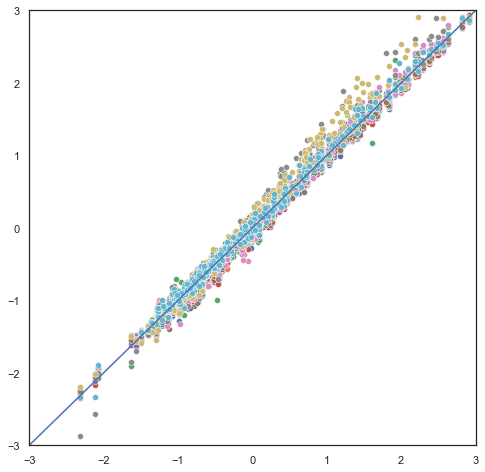

In [125]:
fig, ax = plt.subplots(figsize=(8,8))
[sns.scatterplot(
    x=train_umap_flat_haus.to_numpy(), y=haus.to_numpy(), palette="Paired", 
    ) 
 for haus in flat_haus_umap_loo.values()]

plt.xlim([-3,3])
plt.ylim([-3,3])

sns.lineplot(x=[-3,3], y=[-3,3])
plt.show()

In [126]:
corr_coeff = pd.DataFrame()
haus_umap_flat_df = pd.DataFrame(train_umap_flat_haus)
for haus in flat_haus_umap_loo.values():
    haus = pd.DataFrame(haus)
    corr_coeff = pd.concat([corr_coeff, train_umap_flat_haus.corrwith(haus)], ignore_index=True)
corr_coeff['rm'] = flat_haus_umap_loo.keys()

AttributeError: 'Series' object has no attribute 'corrwith'

In [24]:
corr_coeff

,0,rm
0,0.981999,rm1
1,0.938394,rm2
2,0.976057,rm3
3,0.956829,rm4
4,0.962423,rm5
5,0.936070,rm6
6,0.888167,rm7
7,0.969270,rm8
8,0.783110,rm9
9,0.825210,rm10


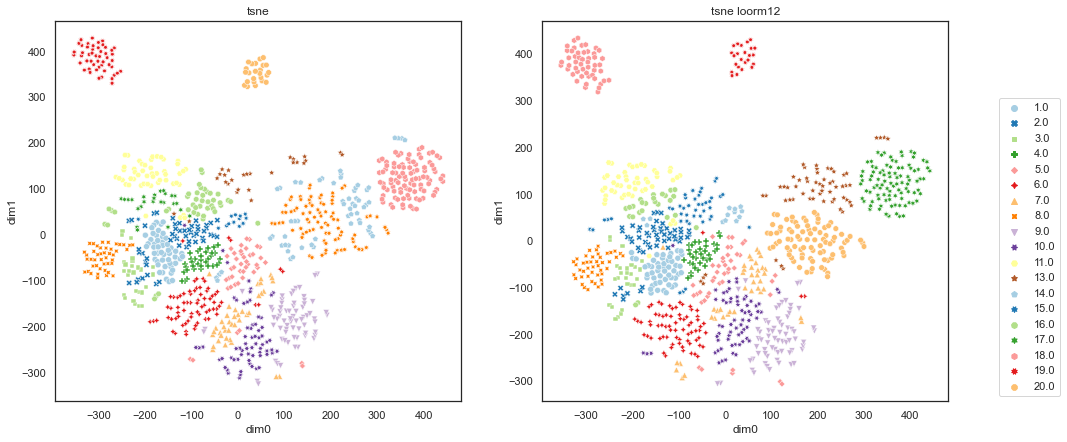

In [206]:
part_r = 'rm12'
test = loo_tsne[part_r]

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16,7))

clust_plt_tsne = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, palette="Paired", 
                                 ax=ax1, hue=emb_tsne.part_id, style=emb_tsne.part_id, legend=False)
clust_plt_tsne.set(title = 'tsne')

clust_plt_tsne_loo = sns.scatterplot(x=test.dim0, y=test.dim1, palette="Paired", 
                                 ax=ax2, hue=test.part_id, style=test.part_id)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2, 0), ncol=1)
clust_plt_tsne_loo.set(title = 'tsne loo' + str(part_r))


plt.show()

In [14]:
metrics = {rm:dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        subsetsize=X.shape[0]
)
 for ([rm,X],Z) in zip(loo.items(), loo_tsne.values())
}

#metrics = {rm:dm.embedding_quality(
#        emb_down.drop(columns='part_id').to_numpy(), 
#        Z.drop(columns='part_id').to_numpy(), 
#        emb_down.part_id.to_numpy(),
#        subsetsize=1000
#)
# for rm,Z in loo_tsne.items()
#}


metrics = pd.DataFrame(metrics.values(), columns=['micro', 'meso', 'macro'], index = metrics.keys())
metrics.mean(axis=0)


micro    0.271056
meso     0.806053
macro    0.593348
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

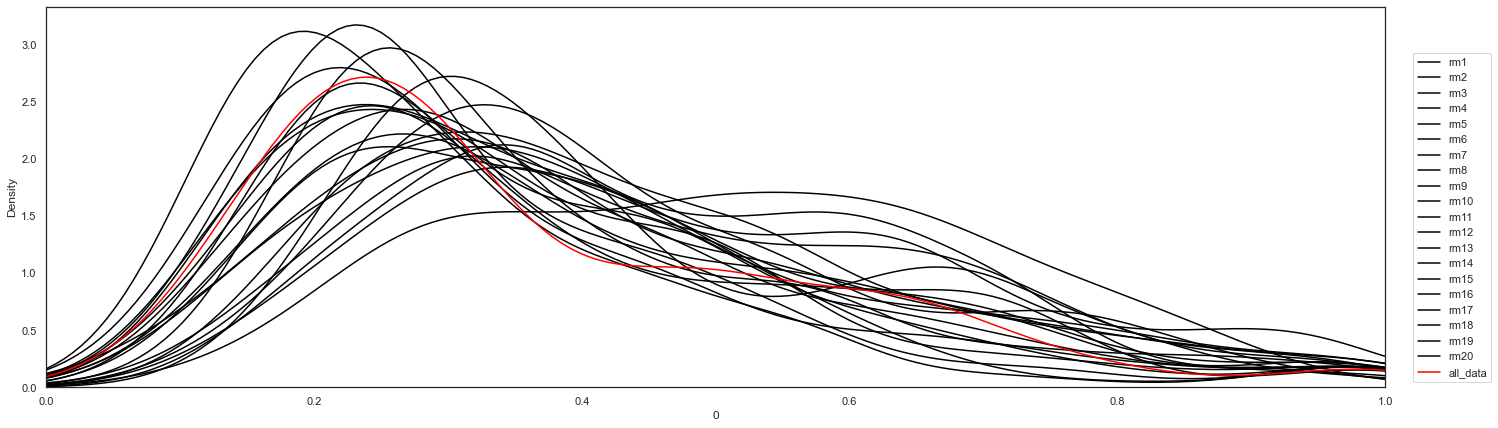

In [44]:
#plots distribution all hausdorff distances. Technically a histogram with easily viewing
fig, ax = plt.subplots(figsize=(24,7))#ncols=3
bins=100

d_plot = [sns.distplot(dist,hist=False, norm_hist=True,label=rm,color='black') for rm,dist in loo_haus_tsne_flat.items()]
a_plot = sns.distplot(haus_tsne_flat,hist=False, norm_hist=True,label='all_data',color='red')
ax.legend(loc="lower center",bbox_to_anchor=(1.05, 0), ncol=1)
plt.xlim(0,1)
plt.show

In [75]:
#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
emb_tsne = dr.run_tsne(emb_down, perplexity=80, init='pca', learning_rate=emb_down.shape[0]//12)
haus_tsne = dm.hausdorff_distances(emb_tsne)

Processing row 19, col 19


In [33]:
haus_tsne_flat = haus_tsne.stack().reset_index().iloc[:,2]  

haus_tsne_flat = haus_tsne_flat[haus_tsne_flat>0]
haus_tsne_flat

1      0.201617
2      0.159276
3      0.213192
4      0.212280
5      0.275035
         ...   
394    0.387642
395    0.374027
396    0.191426
397    0.740169
398    0.231070
Name: 0, Length: 380, dtype: float64

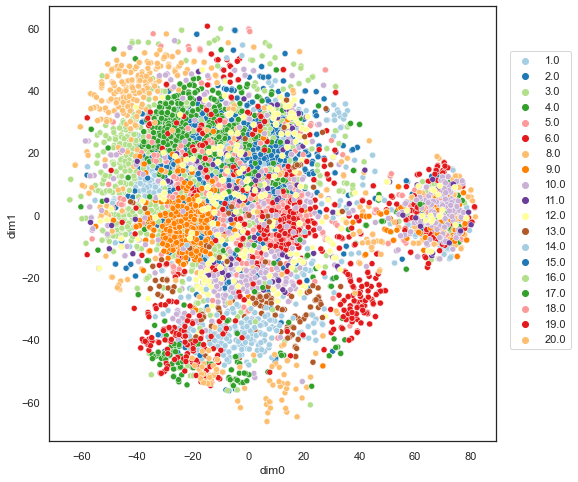

In [77]:
#ttest = dm.loo_t_test(loo_haus_tsne_flat,equal_var=False)
ttest = [stats.ttest_ind(rm,haus_tsne_flat,equal_var=False) for rm in loo_haus_tsne_flat.values()]
a = pd.DataFrame(ttest)
#np.sum(a.pvalue<0.05)

figure, ax = plt.subplots(figsize=(8,8))
rm = 'rm7'
#sns.scatterplot(x='dim0', y='dim1',data=loo_tsne[rm],hue=loo_tsne[rm].part_id, palette="Paired")
sns.scatterplot(x='dim0', y='dim1',data=emb_tsne,hue=loo_tsne[rm].part_id, palette="Paired",)
ax.legend(loc="lower center",bbox_to_anchor=(1.1,0.2))


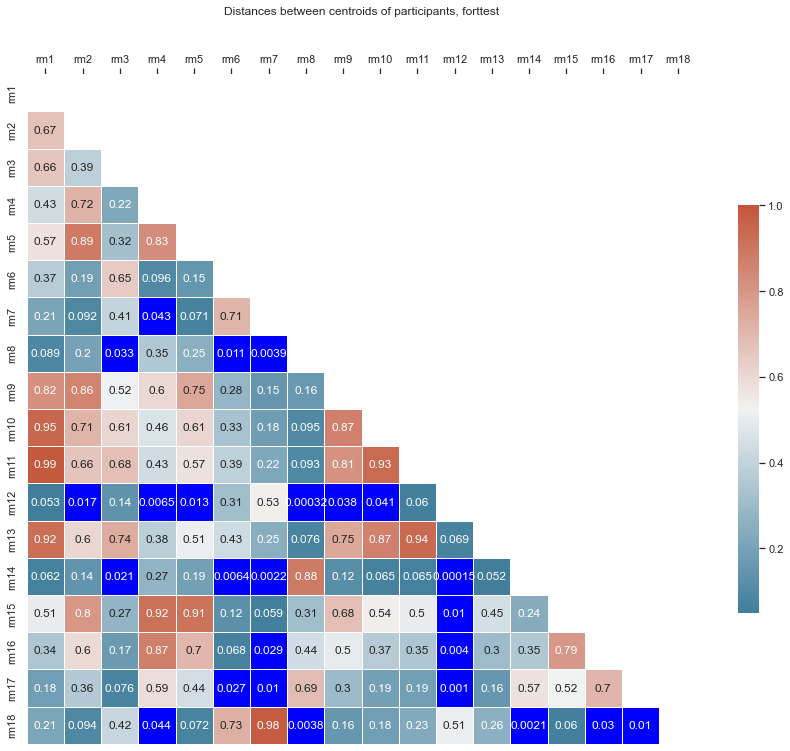

In [52]:
plotting.plot_norm_heatmap(ttest,'ttest')

In [74]:
temp = pd.DataFrame(np.triu(ttest, k=1).flatten())
temp = temp[temp>0].dropna()
temp.ge(0.05).mean().mul(100)


0    83.660131
dtype: float64

In [ ]:
reset_index